In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [14]:
# 1. CARGAR Y PREPARAR LOS DATOS

#df = pd.read_csv('../data/processed/energy_data_processed.csv')
df = pd.read_csv('../data/processed/energy_data_processed_test.csv')

In [15]:
# 2. SEPARAR CARACTERÍSTICAS Y VARIABLE OBJETIVO
# La variable objetivo es 'Energy Consumption'
y = df['Energy Consumption']

# Las características (X) son todas las demás columnas excepto 'Energy Consumption'
X = df.drop('Energy Consumption', axis=1)

print(f"Forma del dataset: {X.shape}")
print(f"Variable objetivo: {y.name}")


Forma del dataset: (1000, 9)
Variable objetivo: Energy Consumption


In [16]:
# 3. DIVISIÓN DE DATOS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. ESCALADO DE CARACTERÍSTICAS
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# 5. MODELO SVR BÁSICO
print("\n=== SVR BÁSICO ===")
svr_basic = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_basic.fit(X_train_scaled, y_train)

# Predicciones básicas
y_pred_basic = svr_basic.predict(X_test_scaled)

# Métricas básicas
mse_basic = mean_squared_error(y_test, y_pred_basic)
rmse_basic = np.sqrt(mse_basic)
r2_basic = r2_score(y_test, y_pred_basic)
mae_basic = mean_absolute_error(y_test, y_pred_basic)

print(f"MSE: {mse_basic:.4f}")
print(f"RMSE: {rmse_basic:.4f}")
print(f"R²: {r2_basic:.4f}")
print(f"MAE: {mae_basic:.4f}")


=== SVR BÁSICO ===
MSE: 770841.4679
RMSE: 877.9758
R²: 0.0534
MAE: 713.4058


In [ ]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

bayes_search = BayesSearchCV(
    SVR(),
    {
        'C': Real(0.1, 100, prior='log-uniform'),
        'gamma': Categorical(['scale', 'auto', 0.001, 0.01, 0.1]),
        'kernel': Categorical(['rbf', 'poly']),
        'epsilon': Real(0.01, 0.2)
    },
    n_iter=30,  # Solo 30 iteraciones inteligentes
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search.fit(X_train_scaled, y_train)
print(f"Mejores parámetros: {bayes_search.best_params_}")
print(f"Mejor score CV: {-bayes_search.best_score_:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
# 7. MODELO OPTIMIZADO
svr_optimized = bayes_search.best_estimator_
y_pred_optimized = svr_optimized.predict(X_test_scaled)

# Métricas del modelo optimizado
mse_opt = mean_squared_error(y_test, y_pred_optimized)
rmse_opt = np.sqrt(mse_opt)
r2_opt = r2_score(y_test, y_pred_optimized)
mae_opt = mean_absolute_error(y_test, y_pred_optimized)

print(f"\n=== MODELO OPTIMIZADO ===")
print(f"MSE: {mse_opt:.4f}")
print(f"RMSE: {rmse_opt:.4f}")
print(f"R²: {r2_opt:.4f}")
print(f"MAE: {mae_opt:.4f}")


=== MODELO OPTIMIZADO ===
MSE: 2476.1800
RMSE: 49.7612
R²: 0.9970
MAE: 36.0889


In [ ]:
cv_scores = cross_val_score(svr_optimized, X_train_scaled, y_train, 
                           cv=5, scoring='neg_mean_squared_error')
print(f"\nCV RMSE: {np.sqrt(-cv_scores.mean()):.4f} (+/- {np.sqrt(cv_scores.std() * 2):.4f})")


CV RMSE: 62.3805 (+/- 29.4309)


In [ ]:
# 9. COMPARACIÓN DE MODELOS CON DIFERENTES KERNELS
print("\n=== COMPARACIÓN DE KERNELS ===")
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

for kernel in kernels:
    svr_kernel = SVR(kernel=kernel, C=1.0, gamma='scale')
    svr_kernel.fit(X_train_scaled, y_train)
    y_pred_kernel = svr_kernel.predict(X_test_scaled)
    
    mse_kernel = mean_squared_error(y_test, y_pred_kernel)
    r2_kernel = r2_score(y_test, y_pred_kernel)
    
    kernel_results[kernel] = {'MSE': mse_kernel, 'R²': r2_kernel}
    print(f"{kernel.upper()} - MSE: {mse_kernel:.4f}, R²: {r2_kernel:.4f}")


=== COMPARACIÓN DE KERNELS ===
LINEAR - MSE: 40470.5514, R²: 0.9503
RBF - MSE: 770841.4679, R²: 0.0534
POLY - MSE: 758768.1876, R²: 0.0682
SIGMOID - MSE: 698007.5264, R²: 0.1428


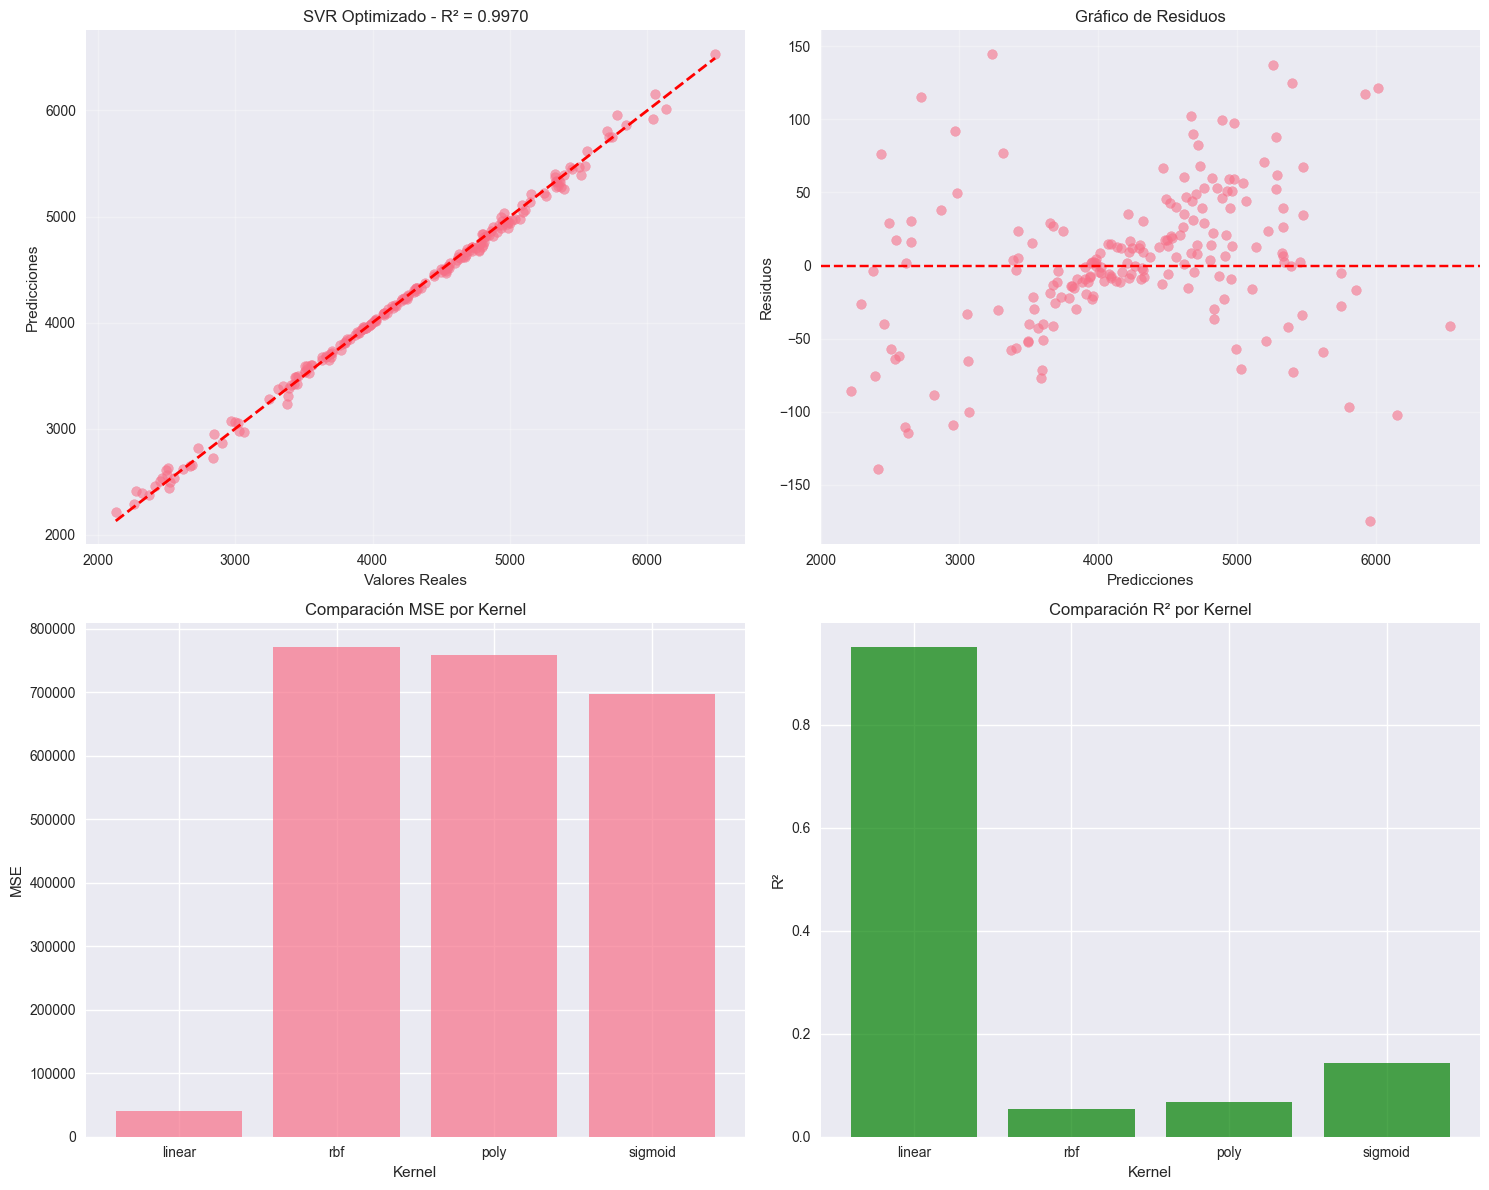

📊 Gráfico guardado en: ../data/figures/svr_comparative_analysis.png


In [ ]:
# 10. VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Valores reales vs predicciones (modelo optimizado)
axes[0,0].scatter(y_test, y_pred_optimized, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valores Reales')
axes[0,0].set_ylabel('Predicciones')
axes[0,0].set_title(f'SVR Optimizado - R² = {r2_opt:.4f}')
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Residuos
residuos = y_test - y_pred_optimized
axes[0,1].scatter(y_pred_optimized, residuos, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicciones')
axes[0,1].set_ylabel('Residuos')
axes[0,1].set_title('Gráfico de Residuos')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Comparación de kernels
kernel_names = list(kernel_results.keys())
mse_values = [kernel_results[k]['MSE'] for k in kernel_names]
r2_values = [kernel_results[k]['R²'] for k in kernel_names]

x_pos = np.arange(len(kernel_names))
axes[1,0].bar(x_pos, mse_values, alpha=0.7)
axes[1,0].set_xlabel('Kernel')
axes[1,0].set_ylabel('MSE')
axes[1,0].set_title('Comparación MSE por Kernel')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(kernel_names)

axes[1,1].bar(x_pos, r2_values, alpha=0.7, color='green')
axes[1,1].set_xlabel('Kernel')
axes[1,1].set_ylabel('R²')
axes[1,1].set_title('Comparación R² por Kernel')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(kernel_names)

plt.tight_layout()
plt.show()

output_dir = "../data/figures/"  # Tu carpeta existente
fig.savefig(f"{output_dir}svr_comparative_analysis.png", dpi=300, bbox_inches='tight')
plt.close(fig)  # Libera memoria
print(f"📊 Gráfico guardado en: {output_dir}svr_comparative_analysis.png")


In [ ]:
# 11. TABLA RESUMEN DE RESULTADOS
print("\n=== RESUMEN DE RESULTADOS ===")
resumen = pd.DataFrame({
    'Modelo': ['SVR Básico', 'SVR Optimizado'],
    'MSE': [mse_basic, mse_opt],
    'RMSE': [rmse_basic, rmse_opt],
    'R²': [r2_basic, r2_opt],
    'MAE': [mae_basic, mae_opt]
})
print(resumen.round(4))


=== RESUMEN DE RESULTADOS ===
           Modelo          MSE      RMSE      R²       MAE
0      SVR Básico  770841.4679  877.9758  0.0534  713.4058
1  SVR Optimizado    2476.1800   49.7612  0.9970   36.0889


In [ ]:
# 12. GUARDAR EL MODELO 
joblib.dump(svr_optimized, '../data/results/svr_model.pkl')
joblib.dump(scaler, '../data/results/svr_scaler.pkl')
print("\nModelo y scaler guardados como 'svr_model.pkl' y 'svr_scaler.pkl'")


FileNotFoundError: [Errno 2] No such file or directory: '../data/results/svr_model.pkl'

In [ ]:
# 13. FUNCIÓN PARA NUEVAS PREDICCIONES
def predecir_nuevos_datos(nuevos_datos, modelo=svr_optimized, escalador=scaler):
    """
    Función para hacer predicciones en nuevos datos
    
    Parameters:
    nuevos_datos: array-like, datos a predecir
    modelo: modelo SVR entrenado
    escalador: StandardScaler ajustado
    
    Returns:
    predicciones: array con las predicciones
    """
    datos_escalados = escalador.transform(nuevos_datos)
    predicciones = modelo.predict(datos_escalados)
    return predicciones

# Ejemplo de uso de la función
# nuevos_X = np.array([[1, 2, 3, 4]])  # Ejemplo
# prediccion = predecir_nuevos_datos(nuevos_X)
# print(f"Predicción para nuevos datos: {prediccion}")

print("\n¡SVR implementado exitosamente!")



¡SVR implementado exitosamente!
